In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import decomposition, manifold, preprocessing, model_selection

sns.set_theme()

### Parameters

In [4]:
test_size = 0.2
train_size = 1 - test_size
random_seed = 42

class_code_to_class_name = {
    1: 'walking',
    2: 'running',
    3: 'shuffling',
    4: 'stairs (ascending)',
    5: 'stairs (descending)',
    6: 'standing',
    7: 'sitting',
    8: 'lying',
    13: 'cycling (sit)',
    14: 'cycling (stand)',
    130: 'cycling (sit, inactive)',
    140: 'cycling (stand, inactive)',
}

class_code_to_id = {}
id_to_class_code = {}
id_to_class_name = {}
for i, code in enumerate(class_code_to_class_name.keys()):
    class_code_to_id[code] = i
    id_to_class_code[i] = code
    id_to_class_name[i] = class_code_to_class_name[code]
    
num_classes = len(class_code_to_id)

In [7]:
def remap_labels(y):
    '''Converts class codes into consecutive ids.'''
    remap_y = y.copy()
    for class_code, class_id in class_code_to_id.items():
        remap_y[y == class_code] = class_id
    return remap_y

X = np.load('./features.npy')
y_orig = np.load('./labels.npy')
y = remap_labels(y_orig)

print(f'Number of classes: {num_classes}')
print(f'Number of features: {X.shape[1]}')
print(f'Number of samples: {X.shape[0]}')

Number of classes: 12
Number of features: 88
Number of samples: 25853


In [8]:
def plot_class_distribution(y, ax, title):
    labels, counts = np.unique(y, return_counts=True)
    counts = counts / counts.sum()
    
    ax.bar(labels, counts, align='center')
    ax.set_xticks(list(id_to_class_name.keys()), list(id_to_class_name.values()), rotation=45, ha='right')
    ax.set_title(title)

### Create test set

Number of train samples: 20682
Number of test samples: 5171


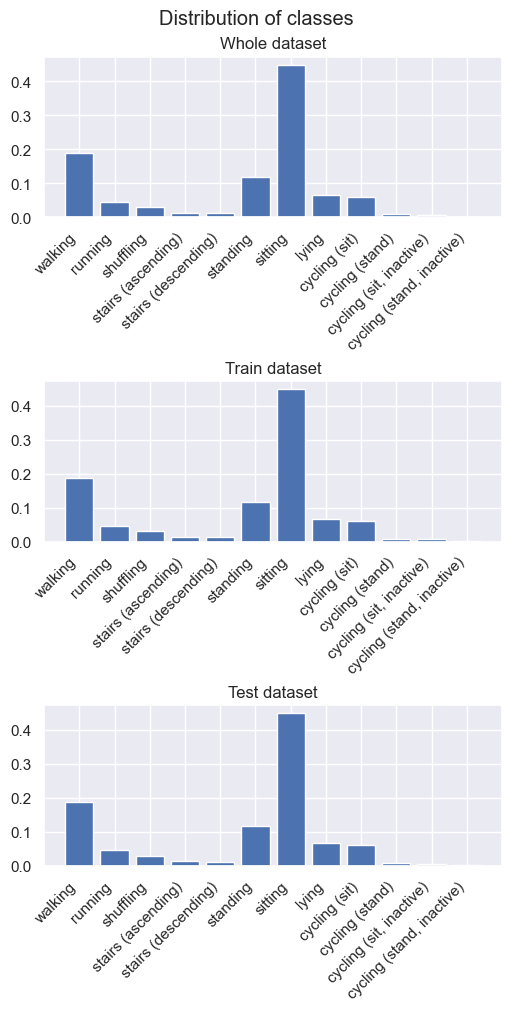

In [9]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    stratify=y,
                                                                    test_size=test_size,
                                                                    random_state=random_seed)
print(f'Number of train samples: {X_train.shape[0]}')
print(f'Number of test samples: {X_test.shape[0]}')

fig = plt.figure(figsize=(5, 10), constrained_layout=True)
gs = fig.add_gridspec(3, 1)

ax = fig.add_subplot(gs[0, 0])
plot_class_distribution(y, ax, title='Whole dataset')

ax = fig.add_subplot(gs[1, 0])
plot_class_distribution(y, ax, title='Train dataset')

ax = fig.add_subplot(gs[2, 0])
plot_class_distribution(y, ax, title='Test dataset')

plt.suptitle('Distribution of classes')
plt.show()
plt.close()

### PCA

In [10]:
def plot_pca(X_pca, y, n_components):
    X_list = [X_pca[:, i] for i in range(n_components)]
    
    if len(X_list) == 3:
        ax = plt.axes(projection='3d')
    else:
        ax = plt.axes()        
    ax.scatter(*X_list, c=y)
    ax.set_title(f'Distribution of data using PCA with {n_components = }')
    plt.show()
    plt.close()

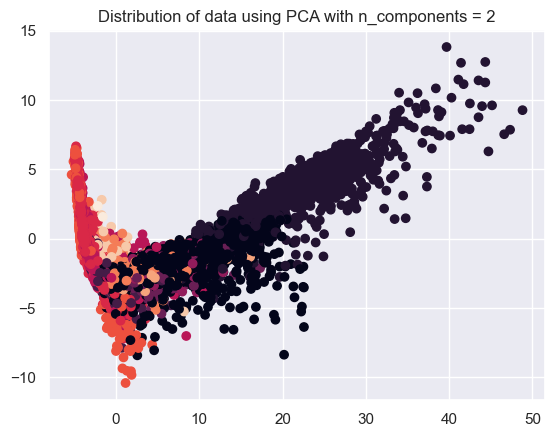

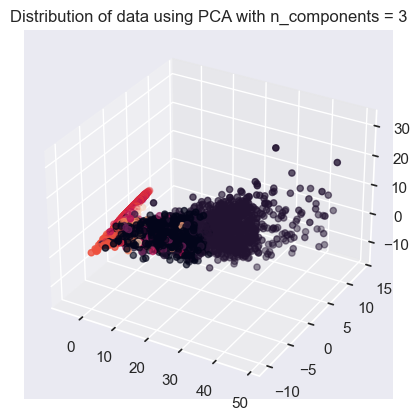

In [11]:
scaler = preprocessing.StandardScaler()
scaler.fit(X_train)
X_train_norm = scaler.transform(X_train)
X_test_norm = scaler.transform(X_test)

pca = decomposition.PCA()
pca.fit(X_train_norm)
X_train_norm_pca = pca.transform(X_train_norm)
X_test_norm_pca = pca.transform(X_test_norm)
        
plot_pca(X_train_norm_pca, y_train, n_components=2)
plot_pca(X_train_norm_pca, y_train, n_components=3)

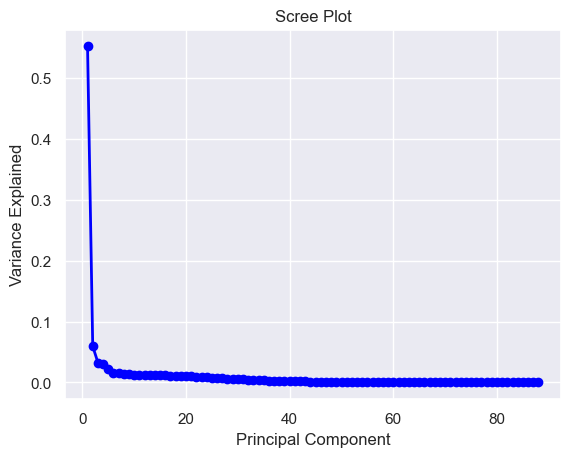

In [12]:
x_ticks = np.arange(pca.n_components_) + 1
plt.plot(x_ticks, pca.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

In [19]:
def compute_model_metrics(model, X, y_true):
    y_pred = model.predict(X)
    
    print("Confusion Matrix")
    confusion_matrix = metrics.confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 8))
    ax = sns.heatmap(confusion_matrix, cmap="crest",  annot=True, fmt="d", linewidths=.1)
    xticks = [i + 0.5 for i in id_to_class_name.keys()]
    ax.set_xticks(
        xticks, list(id_to_class_name.values()), rotation=45, ha='right'
    )
    ax.set_yticks(
        xticks, list(id_to_class_name.values()), rotation=0, va='top'
    )
    ax.set_ylabel("True label")
    ax.set_xlabel("Predicted label")
    plt.show()

    report = metrics.classification_report(
        y_true, y_pred, target_names=list(id_to_class_name.values()), digits=4
    )
    print(report)
    test_acc = metrics.accuracy_score(y_true, y_pred)
    print(f'Accuracy: {test_acc:.4f}')
    
    test_precision = metrics.precision_score(y_true, y_pred, average='micro')
    print(f'Micro Precision: {test_precision:.4f}')
        
    test_recall = metrics.recall_score(y_true, y_pred, average='micro')
    print(f'Micro Recall/TPR: {test_recall:.4f}')
    
    test_f1 = metrics.f1_score(y_true, y_pred, average='micro')
    print(f'Micro f1-score: {test_f1:.4f}')

## XGBoost

In [11]:
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import accuracy_score, make_scorer
from xgboost import XGBClassifier

xgb_clf = XGBClassifier(
    num_class=num_classes,
    objective= 'multi:softmax',
    nthread=4,
    seed=42,
)

parameters = {
    'max_depth': [6, 8, 10],
    'n_estimators': [40, 50, 60],
    'learning_rate': [0.1, 0.01]
}

grid_search = GridSearchCV(
    xgb_clf, parameters, scoring=make_scorer(accuracy_score), cv=5, n_jobs=2, return_train_score=True
)
grid_search.fit(X_train_norm, y_train)
print(f'Best training accuracy with 5-fold cross validation: {grid_search.best_score_}')
print(f'Best parameters: \n{grid_search.best_params_}')

Best training accuracy with 5-fold cross validation: 0.9470555266456551
Best parameters: 
{'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 60}


In [12]:
best_xgb_model = grid_search.best_estimator_
y_test_pred = best_xgb_model.predict(X_test_norm)
acc = accuracy_score(y_test, y_test_pred)
print(f'Best test accuracy after grid search: {acc:.4f}')

Best test accuracy after grid search: 0.9501


In [15]:
xgb_clf = XGBClassifier(
    num_class=num_classes,
    objective= 'multi:softmax',
    learning_rate=0.1,
    n_estimators=60,
    max_depth=8,
    nthread=4,
    seed=42
)

xgb_clf.fit(X_train_norm, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=60, n_jobs=None, nthread=4, num_class=12,
              num_parallel_tree=None, ...)

Confusion Matrix


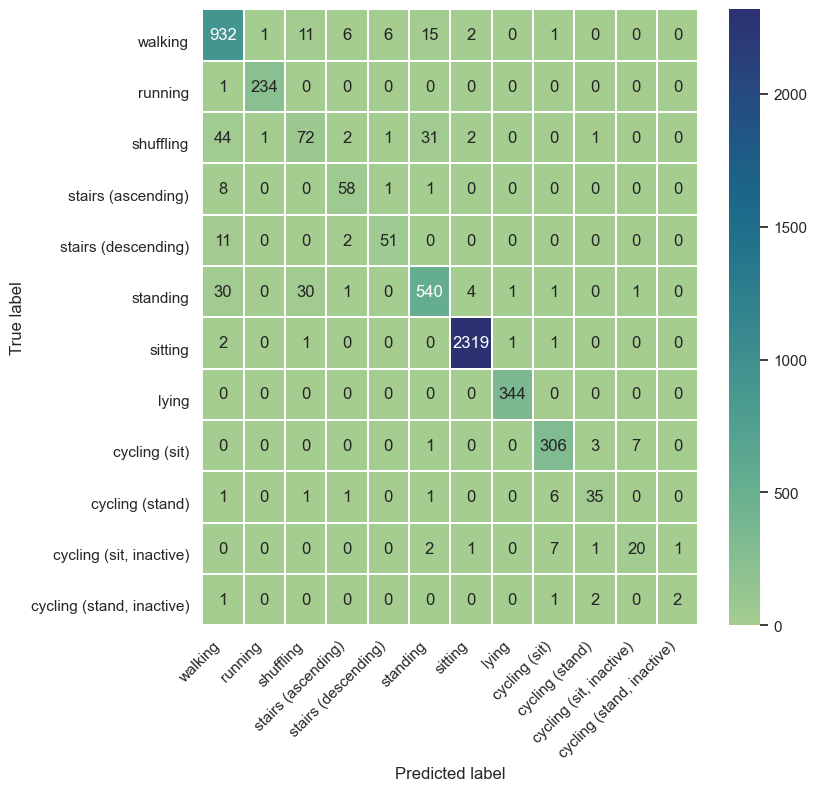

                           precision    recall  f1-score   support

                  walking     0.9049    0.9569    0.9301       974
                  running     0.9915    0.9957    0.9936       235
                shuffling     0.6261    0.4675    0.5353       154
       stairs (ascending)     0.8286    0.8529    0.8406        68
      stairs (descending)     0.8644    0.7969    0.8293        64
                 standing     0.9137    0.8882    0.9008       608
                  sitting     0.9961    0.9978    0.9970      2324
                    lying     0.9942    1.0000    0.9971       344
            cycling (sit)     0.9474    0.9653    0.9562       317
          cycling (stand)     0.8333    0.7778    0.8046        45
  cycling (sit, inactive)     0.7143    0.6250    0.6667        32
cycling (stand, inactive)     0.6667    0.3333    0.4444         6

                 accuracy                         0.9501      5171
                macro avg     0.8568    0.8048    0.8246    

In [17]:
compute_model_metrics(xgb_clf, X_test_norm, y_test)

## SVM

In [14]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.metrics import accuracy_score, make_scorer

# Normalize the features.
scaler = preprocessing.StandardScaler()
scaler.fit(X_train)
X_train_norm = scaler.transform(X_train)
X_test_norm = scaler.transform(X_test)

In [15]:
# Grid search.
parameters = [
    {"kernel": ["rbf"], "gamma": [1e-2, 1e-3, 1e-4], "C": [10, 100, 1000]},
    {"kernel": ["linear"], "C": [1, 10]},
]

grid_search = GridSearchCV(
    SVC(), parameters, scoring=make_scorer(accuracy_score), cv=5, n_jobs=2, return_train_score=True
)
grid_search.fit(X_train_norm, y_train)
print(f'Best training accuracy with 5-fold cross validation: {grid_search.best_score_}')
print(f'Best parameters: \n{grid_search.best_params_}')

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [23]:
best_svc_model = grid_search.best_estimator_
y_test_pred = best_svc_model.predict(X_test_norm)
acc = accuracy_score(y_test, y_test_pred)
print(f'Best test accuracy after grid search: {acc:.4f}')

Best test accuracy after grid search: 0.9435


In [16]:
# Fit using the best model.
svm_clf = SVC(C=100, gamma=0.001, kernel='rbf')
svm_clf.fit(X_train_norm, y_train)

SVC(C=100, gamma=0.001)

Confusion Matrix


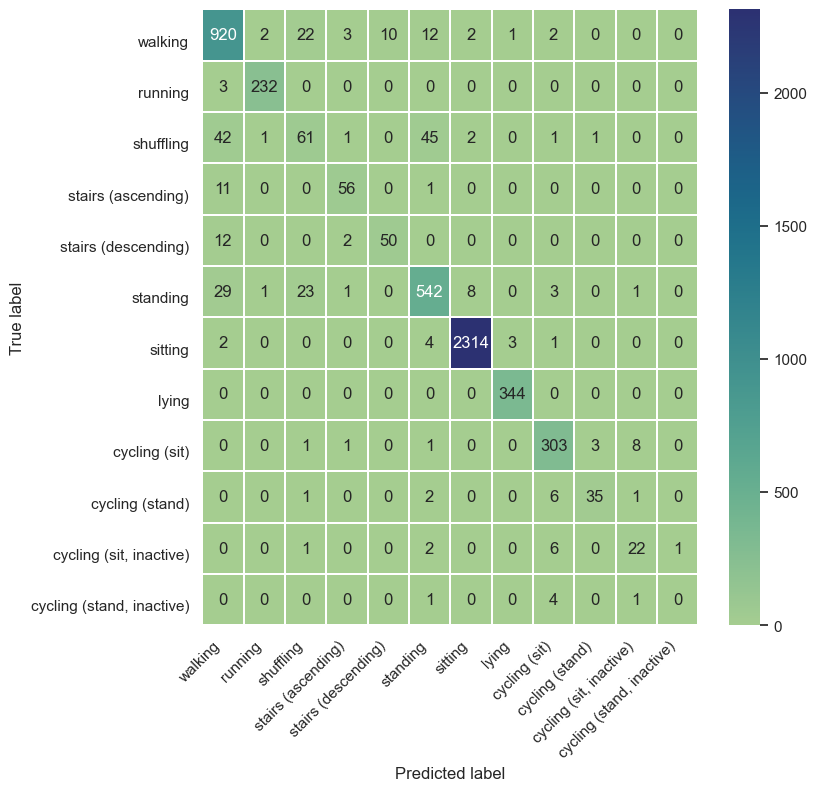

                           precision    recall  f1-score   support

                  walking     0.9028    0.9446    0.9232       974
                  running     0.9831    0.9872    0.9851       235
                shuffling     0.5596    0.3961    0.4639       154
       stairs (ascending)     0.8750    0.8235    0.8485        68
      stairs (descending)     0.8333    0.7812    0.8065        64
                 standing     0.8885    0.8914    0.8900       608
                  sitting     0.9948    0.9957    0.9953      2324
                    lying     0.9885    1.0000    0.9942       344
            cycling (sit)     0.9294    0.9558    0.9425       317
          cycling (stand)     0.8974    0.7778    0.8333        45
  cycling (sit, inactive)     0.6667    0.6875    0.6769        32
cycling (stand, inactive)     0.0000    0.0000    0.0000         6

                 accuracy                         0.9435      5171
                macro avg     0.7933    0.7701    0.7799    

In [22]:
compute_model_metrics(svm_clf, X_test_norm, y_test)

## KNN

## Logistic Regression

## Random Forest

## Performance with dimensionality reduction

In [48]:
def test_with_pca_components(model, X_train, y_train, X_test, y_test, components_list):
    scaler = preprocessing.StandardScaler()
    scaler.fit(X)
    X_train_norm = scaler.transform(X_train)
    X_test_norm = scaler.transform(X_test)

    pca = decomposition.PCA()
    pca.fit(X_train_norm)
    X_train_norm_pca = pca.transform(X_train_norm)
    X_test_norm_pca = pca.transform(X_test_norm)

    accuracies = []
    for n in components_list:
        model.fit(X_train_norm_pca[:, :n], y_train)
        y_test_pred = model.predict(X_test_norm_pca[:, :n])
        acc = metrics.accuracy_score(y_test, y_test_pred)
        accuracies.append(acc)
        print(f'Testing for {n = }, {acc = }')

    return accuracies

In [51]:
models = {
    'svm': SVC(C=100, gamma=0.001, kernel='rbf'),
    'knn': KNeighborsClassifier(n_neighbors=5),
    'logistic_regression': LogisticRegression(
        penalty="l2",
        multi_class='multinomial',
        C=10,
        max_iter=100
    ),
    'xgboost': XGBClassifier(
        num_class=num_classes,
        objective= 'multi:softmax',
        learning_rate=0.1,
        n_estimators=60,
        max_depth=8,
        nthread=4,
        seed=42
    )
}

components = [1, 2, 4, 10, 20, 40, 60, X_train.shape[1]]

accuracies = {}
for name, model in models.items():
    print(f'Running {name}')
    accuracies[name] = test_with_pca_components(model, X_train, y_train, X_test, y_test, components)

Running svm
Testing for n = 1, acc = 0.6824598723651132
Testing for n = 2, acc = 0.6925159543608587
Testing for n = 4, acc = 0.7783794237091471
Testing for n = 10, acc = 0.8878360085089925
Testing for n = 20, acc = 0.9218719783407465
Testing for n = 40, acc = 0.9390833494488493
Testing for n = 60, acc = 0.9435312318700445
Testing for n = 88, acc = 0.9437246180622704
Running knn
Testing for n = 1, acc = 0.6484239025333591


/Users/akankshatyagi/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/akankshatyagi/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None 

Testing for n = 2, acc = 0.6977373815509572
Testing for n = 4, acc = 0.7921098433571843


/Users/akankshatyagi/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


Testing for n = 10, acc = 0.8953780700058016


/Users/akankshatyagi/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


Testing for n = 20, acc = 0.9036936762715142


/Users/akankshatyagi/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


Testing for n = 40, acc = 0.9222587507251983


/Users/akankshatyagi/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


Testing for n = 60, acc = 0.9239992264552311


/Users/akankshatyagi/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


Testing for n = 88, acc = 0.9249661574163605
Running logistic_regression


/Users/akankshatyagi/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Testing for n = 1, acc = 0.67182363179269


/Users/akankshatyagi/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Testing for n = 2, acc = 0.6845871204795978


/Users/akankshatyagi/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Testing for n = 4, acc = 0.7453103848385225


/Users/akankshatyagi/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Testing for n = 10, acc = 0.8512860181783021


/Users/akankshatyagi/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Testing for n = 20, acc = 0.8988590214658674


/Users/akankshatyagi/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Testing for n = 40, acc = 0.9286404950686521


/Users/akankshatyagi/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Testing for n = 60, acc = 0.9392767356410753


/Users/akankshatyagi/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Testing for n = 88, acc = 0.9385031908721717
Running xgboost
Testing for n = 1, acc = 0.6783987623283697
Testing for n = 2, acc = 0.7192032488880294
Testing for n = 4, acc = 0.8068071939663508
Testing for n = 10, acc = 0.905627538193773
Testing for n = 20, acc = 0.9168439373428737
Testing for n = 40, acc = 0.9313479017598143
Testing for n = 60, acc = 0.9356023979887836
Testing for n = 88, acc = 0.9342486946432025


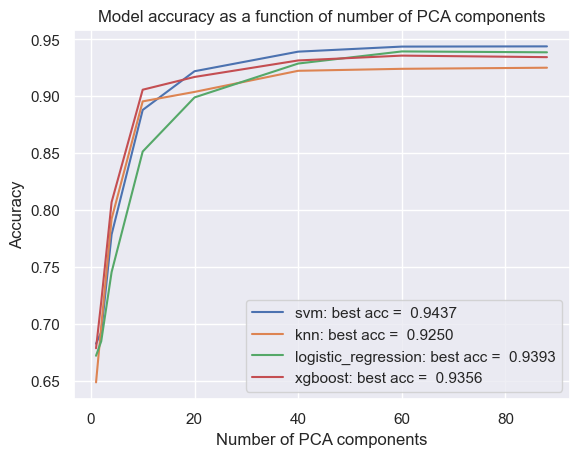

In [116]:
plt.figure()
for name, acc in accuracies.items():
    max_acc = max(acc)
    plt.plot(components, acc, label=f'{name}: best acc = {max_acc: .4f}')
    
plt.xlabel('Number of PCA components')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model accuracy as a function of number of PCA components')
plt.show()

* XGBoost's performance degrades with PCA. It achieves 94.86 % accuracy with raw features as compared to 93.56 % with PCA features.

## TSNE

Running TSNE


/Users/akankshatyagi/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


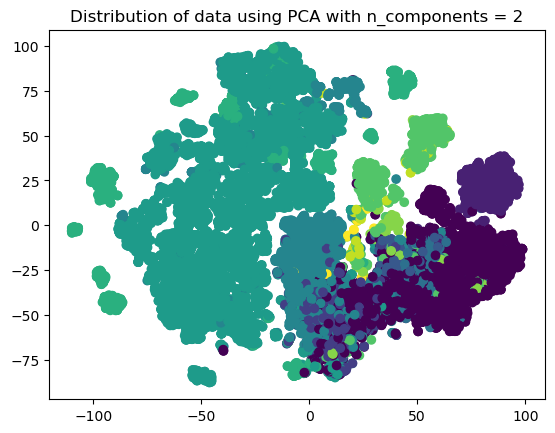

Running TSNE


/Users/akankshatyagi/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


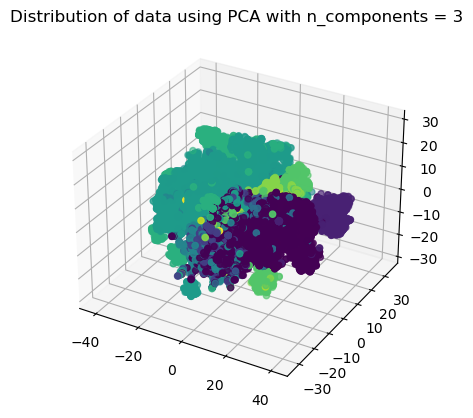

In [7]:
def plot_tsne(X, y, n_components):
    scaler = preprocessing.StandardScaler()
    X = scaler.fit_transform(X)

    print('Running TSNE')
    tsne = manifold.TSNE(
        n_components=n_components,
        init='pca',
        learning_rate='auto',
        n_jobs=4,
        random_state=0,
    )
    X_tsne = tsne.fit_transform(X)
    X_list = [X_tsne[:, i] for i in range(n_components)]
    
    if len(X_list) == 3:
        ax = plt.axes(projection='3d')
    else:
        ax = plt.axes()        
    ax.scatter(*X_list, c=y)
    ax.set_title(f'Distribution of data using TSNE with {n_components = }')
    plt.show()
    plt.close()
    
plot_tsne(X_train, y_train, n_components=2)
plot_tsne(X_train, y_train, n_components=3)